In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")
from coffea import util
import itertools

In [2]:
# analysis categories #
ttagcats = ["AT&Pt", "at", "pret", "0t", "1t", ">=1t", "2t", ">=0t"] 
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

anacats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
label_dict = {i: label for i, label in enumerate(anacats)}
label_to_int_dict = {label: i for i, label in enumerate(anacats)}
label_to_int_dict
signal_cats = [ i for label, i in label_to_int_dict.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int_dict.items() if 'pre' in label]
signal_cats, pretag_cats

([36, 37, 38, 39, 40, 41], [12, 13, 14, 15, 16, 17])

## coffea files

In [3]:
coffea_dir = '../outputs/'
coffeaFiles = {
    "JetHT":{
        "unweighted": {
            "2016APV": {
                "B": coffea_dir+'JetHT_2016APVB.coffea',
                "C": coffea_dir+'JetHT_2016APVC.coffea',
                "D": coffea_dir+'JetHT_2016APVD.coffea',
#                 "E": coffea_dir+'JetHT_2016APVE.coffea',
            },
            "2016": {
                "F": coffea_dir+'JetHT_2016F.coffea',
                "G": coffea_dir+'JetHT_2016G.coffea',
                "H": coffea_dir+'JetHT_2016H.coffea',
            },
            "2017": '',
            "2018": ''
        },
        "weighted": {
            "2016APV": {
                "B": coffea_dir+'JetHT_2016APVB_bkgest.coffea',
                "C": coffea_dir+'JetHT_2016APVC_bkgest.coffea',
                "D": coffea_dir+'JetHT_2016APVD_bkgest.coffea',
#                 "E": coffea_dir+'JetHT_2016APVE_bkgest.coffea',
            },
            "2016": {
                "F": coffea_dir+'JetHT_2016F.coffea',
                "G": coffea_dir+'JetHT_2016G.coffea',
                "H": coffea_dir+'JetHT_2016H.coffea',
            },
            "2017": '',
            "2018": ''
        }
    },
    
    "TTbar": {
        "2016APV": {
            "700to1000": coffea_dir+'TTbar_2016APV_700to1000.coffea',
            "1000toInf": coffea_dir+'TTbar_2016APV_1000toInf.coffea',
        },
        "2016": {
            "700to1000": coffea_dir+'TTbar_2016_700to1000.coffea',
            "1000toInf": coffea_dir+'TTbar_2016_1000toInf.coffea',
        },
        "2017": {
            "700to1000": '',
            "1000toInf": '',
        },
        "2018": {
            "700to1000": '',
            "1000toInf": '',
        }
    }
}




## load and scale histograms

In [4]:

lumi = {
    "2016APV": 19800.,
    "2016": 16120., #35920 - 19800
    "2017": 41530.,
    "2018": 59740.
}

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 1.0 #0.7
qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb


histograms = {}


IOVs = ['2016APV', '2016']

for IOV in IOVs:
    
    
    jethtfiles = []
    
    for key, file in coffeaFiles["JetHT"]["weighted"][IOV].items():
        jethtfiles.append(util.load(file))
    
    jethtfiles_sr = []
    for key, file in coffeaFiles["JetHT"]["unweighted"][IOV].items():
        jethtfiles_sr.append(util.load(file))

    ttbarfiles =  {
        "700to1000": util.load(coffeaFiles["TTbar"][IOV]['700to1000']),
        "1000toInf": util.load(coffeaFiles["TTbar"][IOV]['1000toInf'])
    }
    
    ttbar_sf = {
        "700to1000": lumi[IOV] * ttbar_xs1 * toptag_sf**2 / ttbarfiles['700to1000']['cutflow']['sumw'],
        "1000toInf": lumi[IOV] * ttbar_xs2 * toptag_sf**2 / ttbarfiles['1000toInf']['cutflow']['sumw']
    }
    
    
    mtt_ntmjs = []
    mtt_datas = []
        
    for coffeafile in jethtfiles:
        mtt_ntmjs.append(coffeafile['ttbarmass'][{'dataset':sum, 'anacat':pretag_cats}][{'anacat':sum}])
    for coffeafile in jethtfiles_sr:
        mtt_datas.append(coffeafile['ttbarmass'][{'dataset':sum, 'anacat':signal_cats}][{'anacat':sum}])
        
        
    mtt_ttbars = [
        ttbarfiles['700to1000']['ttbarmass'][{'dataset':sum, 'anacat':signal_cats}][{'anacat':sum}],
        ttbarfiles['1000toInf']['ttbarmass'][{'dataset':sum, 'anacat':signal_cats}][{'anacat':sum}]
    ]
    
    # add together hists in data signal region
    mtt_data = mtt_datas[0]
    for i in range(len(mtt_datas) - 1): 
        mtt_data = mtt_data + mtt_datas[i+1]

    # add together hists in data pretag region, scaled with mistag rate
    mtt_ntmj = mtt_ntmjs[0]
    for i in range(len(mtt_ntmjs) - 1): 
        mtt_ntmj = mtt_ntmj + mtt_ntmjs[i+1]
    
    # add ttbar histograms from 700to1000 pt bin and 1000toInf pt bin
    mtt_ttbar = mtt_ttbars[0] * ttbar_sf['700to1000'] + mtt_ttbars[1] * ttbar_sf['1000toInf']
    
    
    histograms[IOV] = {
                        "data":  mtt_data,
                        "ntmj":  mtt_ntmj,
                        "ttbar": mtt_ttbar
                    }
    

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


## plot histograms

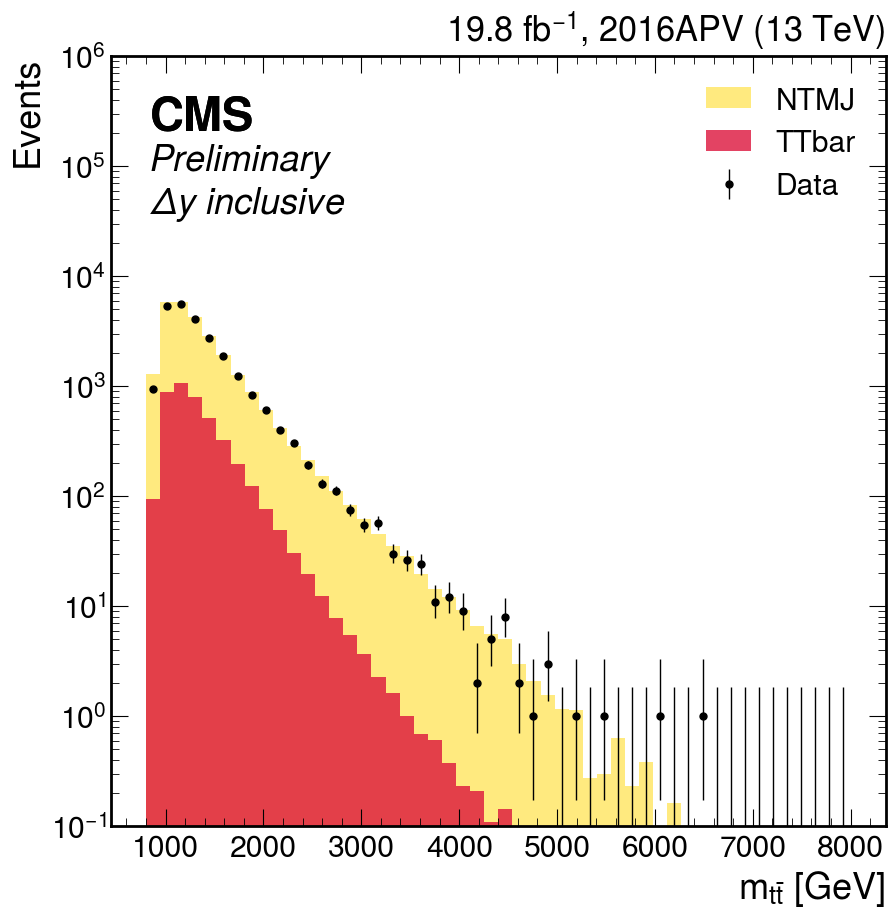

In [7]:
IOV = '2016APV'

hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi[IOV]/1000.), year=IOV, loc=2)
hep.cms.text('Preliminary'+'\n'+r'$\Delta y$ inclusive', loc=2)

hep.histplot(histograms[IOV]['data'], histtype='errorbar', color='black', label='Data')
hep.histplot(histograms[IOV]['ntmj'] + histograms[IOV]['ttbar'], histtype='fill', color='gold', alpha=0.5, label='NTMJ')
# hep.histplot(histograms[IOV]['ttbar'], histtype='fill', color='rosybrown')
hep.histplot(histograms[IOV]['ttbar'], histtype='fill', color='crimson', alpha=0.8, label='TTbar')




plt.legend()
plt.yscale('log')
plt.ylabel('Events')
plt.ylim(1e-1, 1e6)
plt.show()

## 